# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [108]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import re
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Evaluation

First we will evaluate the data to see steps needed to take for cleaning.

In [188]:
# Check portfolio data
portfolio

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  web  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10    1      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10    1      1   
2  3f207df678b143eea3cee63160fa8bed  informational       0    1      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5    1      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5    1      1   
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount       3    1      1   
6  fafdcd668e3743c1bb461111dcafc2a4       discount       2    1      1   
7  5a8bc65990b245e5a138643cd4eb9837  informational       0    1      1   
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo       5    1      1   
9  2906b810c7d4411798c6938adc9daaa5       discount       2    1      1   

   mobile  social  
0       1       0  
1       1       0  
2       1       0  
3       1       0  
4       1       0  
5       1       0  
6       1       0  
7       1       0  
8       1       0  
9       1       0

In [110]:
# Check for nulls
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

-  `channels` may to be broken up into seperate columns.
-  `offer_type` may need to be broken up into different columns.

In [111]:
# Check profile data
profile.head()

age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

In [112]:
# check for nulls
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [113]:
profile.shape

(17000, 5)

In [114]:
profile[profile['gender'].isnull()].head()

age  became_member_on gender                                id  income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783     NaN
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5     NaN
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43     NaN
6  118          20170925   None  8ec6ce2a7e7949b1bf142def7d0e0586     NaN
7  118          20171002   None  68617ca6246f4fbc85e91a2a49552598     NaN

In [115]:
# Check age distribution
plt.hist(profile.age, bins = 20)

(array([  611.,   697.,   649.,   789.,   972.,  1082.,  1607.,  1776.,
         1727.,  1530.,  1174.,   857.,   591.,   375.,   256.,   105.,
           27.,     0.,     0.,  2175.]),
 array([  18.,   23.,   28.,   33.,   38.,   43.,   48.,   53.,   58.,
          63.,   68.,   73.,   78.,   83.,   88.,   93.,   98.,  103.,
         108.,  113.,  118.]),
 <a list of 20 Patch objects>)

- Missing data for gender, income, and age(age=118) is present for 2175 out of 17000.  They make up a little over 12% of the data so we don't want to remove them.  We will impute data so they are a distinct group.
    - age will be randomized.
    - null gender will be changed to unknown
    - gender will be broken up into columns
    - income will randomized.
- `became_member_on` will be changed to number of days they have been a member.

In [116]:
# check transcript data
transcript.head()

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [117]:
# check for nulls
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [118]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

-  `value` will need to pull out value that matches `id` in portfolio
-  `event` may need to be broken up.

# Data cleaning

#### To Do

###### Portfolio
-  `channels` will need to be broken up using string split and made into seperate columns.
-  `offer_type` will be broken into seperate columns

###### Profile
- Missing data for gender, income, and age(age=118) is present for 2175 out of 17000.  They make up a little over 12% of the data so we don't want to remove them.  We will impute data so they are a distinct group.
    - age will be randomized.
    - null gender will be changed to unknown
    - gender will be broken into columns
    - income will randomized.
- `became_member_on` will be changed to number of days they have been a member.

###### Transcript
-  `value` may need to be broken up.
-  `event` may need to be broken up.


#### Portfolio Cleaning

-  `channels` will be broken up into columns.
-  `offer_type` will be broken up into columns.

In [119]:
# Create columns of 1's and 0's for channel type
channel_items = ['web','email','mobile','social']

for channel in portfolio['channels']:
    for item in channel_items:
        if item in channel:
            portfolio[item] = 1
        else:
            portfolio[item] = 0 

In [120]:
# check for correct implementation
portfolio.head()

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  web  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10    1      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10    1      1   
2  3f207df678b143eea3cee63160fa8bed  informational       0    1      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5    1      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5    1      1   

   mobile  social  
0       1       0  
1       1       0  
2       1       0  
3       1       0  
4       1       0

In [121]:
# break offer_type into columns
portfolio_merged = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])],axis=1)

In [122]:
#Check for correct implementation
portfolio_merged.head()

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  web  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10    1      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10    1      1   
2  3f207df678b143eea3cee63160fa8bed  informational       0    1      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5    1      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5    1      1   

   mobile  social  bogo  discount  informational  
0       1       0     1         0              0  
1       1       0     1         0              0  
2       1       0     0         0              1  
3       1       0     1         0              0  
4       1       0     0         1              0

In [123]:
# Drop columns channels and offer_type
portfolio_clean = portfolio_merged.drop(['channels','offer_type'],axis=1)
portfolio_clean.head()

difficulty  duration                                id  reward  web  email  \
0          10         7  ae264e3637204a6fb9bb56bc8210ddfd      10    1      1   
1          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0      10    1      1   
2           0         4  3f207df678b143eea3cee63160fa8bed       0    1      1   
3           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9       5    1      1   
4          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7       5    1      1   

   mobile  social  bogo  discount  informational  
0       1       0     1         0              0  
1       1       0     1         0              0  
2       1       0     0         0              1  
3       1       0     1         0              0  
4       1       0     0         1              0

#### Profile Cleaning

- Missing data for gender, income, and age(age=118) is present for 2175 out of 17000.  They make up a little over 12% of the data so we don't want to remove them.  We will impute data so they are a distinct group.
    - age will be randomized.
    - null gender will be changed to unknown
    - gender will be broken into columns
    - income will randomized.
- `became_member_on` will be changed to number of days they have been a member.

In [124]:
profile.head()

age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

In [125]:
# Input unknown into null values
profile['gender'][profile['gender'].isnull()] = 'unknown'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [126]:
# Check for value counts
profile['gender'].value_counts()

M          8484
F          6129
unknown    2175
O           212
Name: gender, dtype: int64

In [127]:
# Check for null values
profile['gender'].isnull().sum()

0

In [128]:
# break offer_type into columns
profile_merged = pd.concat([profile, pd.get_dummies(profile['gender'])],axis=1)
profile_merged.head()

age  became_member_on   gender                                id    income  \
0  118          20170212  unknown  68be06ca386d4c31939f3a4f0e3dd783       NaN   
1   55          20170715        F  0610b486422d4921ae7d2bf64640c50b  112000.0   
2  118          20180712  unknown  38fe809add3b4fcf9315a9694bb96ff5       NaN   
3   75          20170509        F  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
4  118          20170804  unknown  a03223e636434f42ac4c3df47e8bac43       NaN   

   F  M  O  unknown  
0  0  0  0        1  
1  1  0  0        0  
2  0  0  0        1  
3  1  0  0        0  
4  0  0  0        1

In [129]:
# Moving to Income
profile_merged['income'].isnull().sum()

2175

In [130]:
# Check income distribution
plt.hist(profile_merged['income'][profile_merged['income'].notnull()], bins = 20)

(array([  939.,   792.,   958.,   749.,  1145.,  1089.,  1279.,   931.,
         1158.,  1187.,   881.,   554.,   718.,   497.,   620.,   370.,
          276.,   222.,   257.,   203.]),
 array([  30000.,   34500.,   39000.,   43500.,   48000.,   52500.,
          57000.,   61500.,   66000.,   70500.,   75000.,   79500.,
          84000.,   88500.,   93000.,   97500.,  102000.,  106500.,
         111000.,  115500.,  120000.]),
 <a list of 20 Patch objects>)

In [131]:
# Impute random incomes into income
num_null = profile_merged['income'].isnull().sum()

income_samples = random.choices(list(profile_merged['income'][profile_merged['income'].notnull()]),k=num_null)
n = 0

for idx in range(0,profile_merged.shape[0]):
    if math.isnan(profile_merged['income'][idx]):
        profile_merged['income'][idx] = income_samples[n]
        n+=1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [132]:
#Check for nulls
profile_merged['income'].isnull().sum()

0

(array([ 1072.,   906.,  1095.,   840.,  1289.,  1258.,  1469.,  1089.,
         1342.,  1366.,  1007.,   639.,   818.,   567.,   716.,   422.,
          324.,   269.,   291.,   221.]),
 array([  30000.,   34500.,   39000.,   43500.,   48000.,   52500.,
          57000.,   61500.,   66000.,   70500.,   75000.,   79500.,
          84000.,   88500.,   93000.,   97500.,  102000.,  106500.,
         111000.,  115500.,  120000.]),
 <a list of 20 Patch objects>)

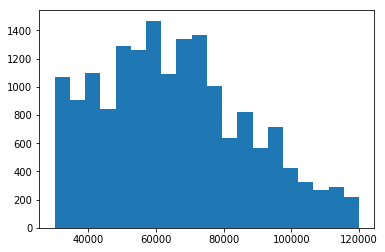

In [133]:
# Check new income distribution
plt.hist(profile_merged['income'], bins = 20)

In [134]:
profile_merged.head()

age  became_member_on   gender                                id    income  \
0  118          20170212  unknown  68be06ca386d4c31939f3a4f0e3dd783  107000.0   
1   55          20170715        F  0610b486422d4921ae7d2bf64640c50b  112000.0   
2  118          20180712  unknown  38fe809add3b4fcf9315a9694bb96ff5   38000.0   
3   75          20170509        F  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
4  118          20170804  unknown  a03223e636434f42ac4c3df47e8bac43   91000.0   

   F  M  O  unknown  
0  0  0  0        1  
1  1  0  0        0  
2  0  0  0        1  
3  1  0  0        0  
4  0  0  0        1

(array([  611.,   697.,   649.,   789.,   972.,  1082.,  1607.,  1776.,
         1727.,  1530.,  1174.,   857.,   591.,   375.,   256.,   105.,
           27.,     0.,     0.,  2175.]),
 array([  18.,   23.,   28.,   33.,   38.,   43.,   48.,   53.,   58.,
          63.,   68.,   73.,   78.,   83.,   88.,   93.,   98.,  103.,
         108.,  113.,  118.]),
 <a list of 20 Patch objects>)

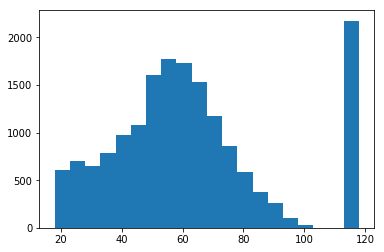

In [135]:
#Check initial age distribution
plt.hist(profile_merged['age'], bins = 20)

In [136]:
#Change age == 118 to a random sample
num_118 = sum(profile_merged['age']==118)

age_samples = random.choices(list(profile_merged['age'][profile_merged['age']!=118]),k=num_118)
n = 0

for idx in range(0,profile_merged.shape[0]):
    if profile_merged['age'][idx] == 118:
        profile_merged['age'][idx] = age_samples[n]
        n+=1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(array([  699.,   626.,   627.,   631.,   746.,   908.,  1220.,  1446.,
         1664.,  1683.,  1491.,  1373.,  1114.,  1037.,   593.,   474.,
          297.,   216.,   110.,    45.]),
 array([  18.  ,   22.15,   26.3 ,   30.45,   34.6 ,   38.75,   42.9 ,
          47.05,   51.2 ,   55.35,   59.5 ,   63.65,   67.8 ,   71.95,
          76.1 ,   80.25,   84.4 ,   88.55,   92.7 ,   96.85,  101.  ]),
 <a list of 20 Patch objects>)

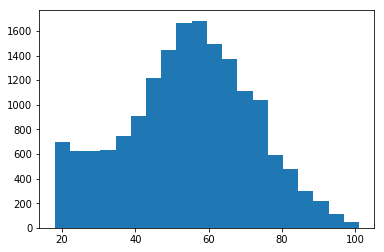

In [137]:
#Check new distribution
plt.hist(profile_merged['age'], bins = 20)

In [138]:
# Change became_member_on to days_as_member
days_as_member = []
today = datetime.datetime.today()
for idx in range(0,profile_merged.shape[0]):
    start_date = datetime.datetime.strptime(str(profile_merged['became_member_on'][idx]),"%Y%m%d")
    days_as_member.append((today-start_date).days)
profile_merged['days_as_member'] = days_as_member

In [139]:
profile_clean = profile_merged.drop(['gender','became_member_on'],axis=1)

In [140]:
#Check data 
profile_clean.head(10)

age                                id    income  F  M  O  unknown  \
0   58  68be06ca386d4c31939f3a4f0e3dd783  107000.0  0  0  0        1   
1   55  0610b486422d4921ae7d2bf64640c50b  112000.0  1  0  0        0   
2   49  38fe809add3b4fcf9315a9694bb96ff5   38000.0  0  0  0        1   
3   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0  1  0  0        0   
4   53  a03223e636434f42ac4c3df47e8bac43   91000.0  0  0  0        1   
5   68  e2127556f4f64592b11af22de27a7932   70000.0  0  1  0        0   
6   70  8ec6ce2a7e7949b1bf142def7d0e0586   82000.0  0  0  0        1   
7   64  68617ca6246f4fbc85e91a2a49552598   39000.0  0  0  0        1   
8   65  389bc3fa690240e798340f5a15918d5c   53000.0  0  1  0        0   
9   82  8974fc5686fe429db53ddde067b88302   55000.0  0  0  0        1   

   days_as_member  
0             886  
1             733  
2             371  
3             800  
4             713  
5             448  
6             661  
7             654  
8             524  
9             968

#### Transcript Cleaing

-  offer id will be pulled out of `value`
-  `event` will be broken into columns

In [141]:
# Pull offer id, reward, and transaction amount out of value
# Break event into multiple columns
people = transcript['person'].drop_duplicates()
transaction_df = pd.DataFrame({'person':[],'offer_id':[],'offer_recieved':[],
                              'offer_viewed':[],'offer_completed':[],
                              'reward':[],'transaction_amount':[]})

for person in people:
# for each person

    #create df of each person
    person_df = transcript[transcript['person']==person]

    #create offer recieved df
    person_event_df = person_df[person_df['event']=='offer received']
    
    #Create blank lists to append
    offer_id_list = []
    offer_recieved_list = []
    offer_viewed_list = []
    offer_completed_list = []
    reward_list = []
    transaction_amount_list = []

    # Go through each person
    for idx in range(0,person_event_df.shape[0]):
        #Get offer id
        offer_id = person_event_df.iloc[idx,:]['value']['offer id']
        offer_id_list.append(offer_id)

        #Subset by offer duration
        offer_duration = (portfolio_clean[portfolio_clean['id'] == offer_id]['duration'])*24
        initial_time = person_event_df.iloc[idx,:]['time']
        end_time = int(initial_time + offer_duration)
        start_window_df = person_df[person_df['time'] >= initial_time]
        time_window_df = start_window_df[start_window_df['time']<=end_time]

        #set offer recieved status
        or_time_window_df = time_window_df[time_window_df['event']=='offer received']
        n=0
        for event in or_time_window_df['value']:
            if event['offer id'] == offer_id:
                n+=1
        n = 1 if n>=1 else 0
        offer_recieved_list.append(n)

        #set offer viewed status
        ov_time_window_df = time_window_df[time_window_df['event']=='offer viewed']
        n=0
        for event in ov_time_window_df['value']:
            if event['offer id'] == offer_id:
                n+=1
        n = 1 if n>=1 else 0
        offer_viewed_list.append(n)

        #set offer completed status
        oc_time_window_df = time_window_df[time_window_df['event']=='offer completed']
        n=0
        for event in oc_time_window_df['value']:
            if event['offer_id'] == offer_id:
                n+=1
                reward = event['reward']
        n = 1 if n>=1 else 0
        offer_completed_list.append(n)
        reward_list.append(reward)

        #calculate transaction amount
        t_time_window_df = time_window_df[time_window_df['event']=='transaction']
        n=0
        for event in t_time_window_df['value']:
            n += event['amount']
        transaction_amount_list.append(n)    

    num_rows = len(offer_id_list)    
    person_list = [person] * num_rows
    
    #Put it all the data to gether for each person
    interaction_df = pd.DataFrame({'person':person_list,'offer_id':offer_id_list,'offer_recieved':offer_recieved_list,
                                  'offer_viewed':offer_viewed_list,'offer_completed':offer_completed_list,
                                  'reward':reward_list,'transaction_amount':transaction_amount_list})
    
    # add person info to transaction_df
    
    transaction_df = pd.concat([transaction_df,interaction_df],axis=0, ignore_index=True)
    

In [142]:
# Create column showing transaction minus reward
transaction_df['net_transaction'] = transaction_df['transaction_amount'] - transaction_df['reward']
transaction_df.head()

person                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  78afa995795e4d85b5d9ceeca43f5fef  5a8bc65990b245e5a138643cd4eb9837   
2  78afa995795e4d85b5d9ceeca43f5fef  ae264e3637204a6fb9bb56bc8210ddfd   
3  78afa995795e4d85b5d9ceeca43f5fef  f19421c1d4aa40978ebb69ca19b0e20d   
4  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   offer_recieved  offer_viewed  offer_completed  reward  transaction_amount  \
0             1.0           1.0              1.0     5.0               37.67   
1             1.0           1.0              0.0     5.0               49.39   
2             1.0           1.0              1.0    10.0               48.28   
3             1.0           1.0              1.0     5.0               48.28   
4             1.0           1.0              0.0     5.0                1.09   

   net_transaction  
0            32.67  
1            44.39  
2            38.28  
3            43.28  
4            -3.91

#### Finalizing data

-  We will combine all 3 data sets using the `transaction_df` as a base.
-  We will need to drop rows where an individual did not view the offer.

In [143]:
#Change column name id to person
profile_clean2 = profile_clean.rename({'id':'person'}, axis=1)
profile_clean2.head()

age                            person    income  F  M  O  unknown  \
0   58  68be06ca386d4c31939f3a4f0e3dd783  107000.0  0  0  0        1   
1   55  0610b486422d4921ae7d2bf64640c50b  112000.0  1  0  0        0   
2   49  38fe809add3b4fcf9315a9694bb96ff5   38000.0  0  0  0        1   
3   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0  1  0  0        0   
4   53  a03223e636434f42ac4c3df47e8bac43   91000.0  0  0  0        1   

   days_as_member  
0             886  
1             733  
2             371  
3             800  
4             713

In [144]:
#Chnage column name id to offer_id
portfolio_clean2 = portfolio_clean.rename({'id':'offer_id'},axis=1)
portfolio_clean2.head()

difficulty  duration                          offer_id  reward  web  email  \
0          10         7  ae264e3637204a6fb9bb56bc8210ddfd      10    1      1   
1          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0      10    1      1   
2           0         4  3f207df678b143eea3cee63160fa8bed       0    1      1   
3           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9       5    1      1   
4          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7       5    1      1   

   mobile  social  bogo  discount  informational  
0       1       0     1         0              0  
1       1       0     1         0              0  
2       1       0     0         0              1  
3       1       0     1         0              0  
4       1       0     0         1              0

In [145]:
#Combine profile data
prelim_df = transaction_df.merge(profile_clean2, on ='person')
prelim_df.head(8)

person                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  78afa995795e4d85b5d9ceeca43f5fef  5a8bc65990b245e5a138643cd4eb9837   
2  78afa995795e4d85b5d9ceeca43f5fef  ae264e3637204a6fb9bb56bc8210ddfd   
3  78afa995795e4d85b5d9ceeca43f5fef  f19421c1d4aa40978ebb69ca19b0e20d   
4  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   
5  a03223e636434f42ac4c3df47e8bac43  3f207df678b143eea3cee63160fa8bed   
6  a03223e636434f42ac4c3df47e8bac43  5a8bc65990b245e5a138643cd4eb9837   
7  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   offer_recieved  offer_viewed  offer_completed  reward  transaction_amount  \
0             1.0           1.0              1.0     5.0               37.67   
1             1.0           1.0              0.0     5.0               49.39   
2             1.0           1.0              1.0    10.0               48.28   
3             1.0           1.0              1.0     5.0               48.28   
4             1.0           1.0              0.0     5.0                1.09   
5             1.0           1.0              0.0     5.0                0.00   
6             1.0           0.0              0.0     5.0                0.00   
7             1.0           1.0              0.0     5.0                0.06   

   net_transaction  age    income  F  M  O  unknown  days_as_member  
0            32.67   75  100000.0  1  0  0        0             800  
1            44.39   75  100000.0  1  0  0        0             800  
2            38.28   75  100000.0  1  0  0        0             800  
3            43.28   75  100000.0  1  0  0        0             800  
4            -3.91   53   91000.0  0  0  0        1             713  
5            -5.00   53   91000.0  0  0  0        1             713  
6            -5.00   53   91000.0  0  0  0        1             713  
7            -4.94   53   91000.0  0  0  0        1             713

In [146]:
# Combine portfolio data
final_df = prelim_df.merge(portfolio_clean2, on = 'offer_id')
final_df.head()

person                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  e2127556f4f64592b11af22de27a7932  9b98b8c7a33c4b65b9aebfe6a799e6d9   
2  68617ca6246f4fbc85e91a2a49552598  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3  389bc3fa690240e798340f5a15918d5c  9b98b8c7a33c4b65b9aebfe6a799e6d9   
4  389bc3fa690240e798340f5a15918d5c  9b98b8c7a33c4b65b9aebfe6a799e6d9   

   offer_recieved  offer_viewed  offer_completed  reward_x  \
0             1.0           1.0              1.0       5.0   
1             1.0           1.0              1.0       5.0   
2             1.0           1.0              0.0       2.0   
3             1.0           1.0              0.0       5.0   
4             1.0           1.0              1.0       5.0   

   transaction_amount  net_transaction  age    income      ...        \
0               37.67            32.67   75  100000.0      ...         
1               18.42            13.42   68   70000.0      ...         
2                0.05            -1.95   64   39000.0      ...         
3                0.00            -5.00   65   53000.0      ...         
4               15.63            10.63   65   53000.0      ...         

   difficulty  duration  reward_y  web  email  mobile  social  bogo  discount  \
0           5         7         5    1      1       1       0     1         0   
1           5         7         5    1      1       1       0     1         0   
2           5         7         5    1      1       1       0     1         0   
3           5         7         5    1      1       1       0     1         0   
4           5         7         5    1      1       1       0     1         0   

   informational  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 25 columns]

In [147]:
#Drop rows where individual did not view offer
final_df = final_df.drop(final_df[final_df['offer_viewed']==0].index,axis=0)

In [148]:
# Check for correction
final_df['offer_viewed'].value_counts()

1.0    56895
Name: offer_viewed, dtype: int64

- Lastly we will make a cleaning data function

In [149]:
def clean_data(portfolio=portfolio, profile=profile, transcript=transcript):
    '''
    Input:
    - portfolio = portfolio data
    - profile = profile data
    - transcript = transcript data
    
    Output:
    - final_df = cleaned dataframe that combines portfolio, profile, and transcript data
    
    
    '''
    ########################
    #Portfolio Cleaning
    # Create columns of 1's and 0's for channel type
    channel_items = ['web','email','mobile','social']

    for channel in portfolio['channels']:
        for item in channel_items:
            if item in channel:
                portfolio[item] = 1
            else:
                portfolio[item] = 0 

    # break offer_type into columns
    portfolio_merged = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])],axis=1)  

    # Drop columns channels and offer_type
    portfolio_clean = portfolio_merged.drop(['channels','offer_type'],axis=1)

    ##########################
    #Profile Cleaning
    # Input unknown into null values
    profile['gender'][profile['gender'].isnull()] = 'unknown'
    
    # break offer_type into columns
    profile = pd.concat([profile, pd.get_dummies(profile['gender'])],axis=1)    

    # Impute random incomes into income==null
    num_null = profile['income'].isnull().sum()

    income_samples = random.choices(list(profile['income'][profile['income'].notnull()]),k=num_null)
    n = 0

    for idx in range(0,profile.shape[0]):
        if math.isnan(profile['income'][idx]):
            profile['income'][idx] = income_samples[n]
            n+=1

    #Change age == 118 to a random sample
    num_118 = sum(profile['age']==118)

    age_samples = random.choices(list(profile['age'][profile['age']!=118]),k=num_118)
    n = 0

    for idx in range(0,profile.shape[0]):
        if profile['age'][idx] == 118:
            profile['age'][idx] = age_samples[n]
            n+=1      

    # Change became_member_on to days_as_member
    days_as_member = []
    today = datetime.datetime.today()
    for idx in range(0,profile.shape[0]):
        start_date = datetime.datetime.strptime(str(profile['became_member_on'][idx]),"%Y%m%d")
        days_as_member.append((today-start_date).days)
    profile['days_as_member'] = days_as_member

    profile_clean = profile.drop(['gender','became_member_on'],axis=1)

    ###########################
    #Transcript cleaing
    # Pull offer id, reward, and transaction amount out of value
    # Break event into multiple columns
    people = transcript['person'].drop_duplicates()
    transaction_df = pd.DataFrame({'person':[],'offer_id':[],'offer_recieved':[],
                                  'offer_viewed':[],'offer_completed':[],
                                  'reward':[],'transaction_amount':[]})

    for person in people:
    # for each person

        #create df of each person
        person_df = transcript[transcript['person']==person]

        #create offer recieved df
        person_event_df = person_df[person_df['event']=='offer received']

        #Create blank lists to append
        offer_id_list = []
        offer_recieved_list = []
        offer_viewed_list = []
        offer_completed_list = []
        reward_list = []
        transaction_amount_list = []

        # Go through each person
        for idx in range(0,person_event_df.shape[0]):
            #Get offer id
            offer_id = person_event_df.iloc[idx,:]['value']['offer id']
            offer_id_list.append(offer_id)

            #Subset by offer duration
            offer_duration = (portfolio_clean[portfolio_clean['id'] == offer_id]['duration'])*24
            initial_time = person_event_df.iloc[idx,:]['time']
            end_time = int(initial_time + offer_duration)
            start_window_df = person_df[person_df['time'] >= initial_time]
            time_window_df = start_window_df[start_window_df['time']<=end_time]

            #set offer recieved status
            or_time_window_df = time_window_df[time_window_df['event']=='offer received']
            n=0
            for event in or_time_window_df['value']:
                if event['offer id'] == offer_id:
                    n+=1
            #n = 1 if n>=1 else 0
            offer_recieved_list.append(n)

            #set offer viewed status
            ov_time_window_df = time_window_df[time_window_df['event']=='offer viewed']
            n=0
            for event in ov_time_window_df['value']:
                if event['offer id'] == offer_id:
                    n+=1
            #n = 1 if n>=1 else 0
            offer_viewed_list.append(n)

            #set offer completed status
            oc_time_window_df = time_window_df[time_window_df['event']=='offer completed']
            n=0
            for event in oc_time_window_df['value']:
                if event['offer_id'] == offer_id:
                    n+=1
                    reward = event['reward']
            #n = 1 if n>=1 else 0
            offer_completed_list.append(n)
            reward_list.append(reward)

            #set offer recieved status
            t_time_window_df = time_window_df[time_window_df['event']=='transaction']
            n=0
            for event in t_time_window_df['value']:
                n += event['amount']
            transaction_amount_list.append(n)    

        num_rows = len(offer_id_list)    
        person_list = [person] * num_rows

        #Put it all the data to gether for each person
        interaction_df = pd.DataFrame({'person':person_list,'offer_id':offer_id_list,'offer_recieved':offer_recieved_list,
                                      'offer_viewed':offer_viewed_list,'offer_completed':offer_completed_list,
                                      'reward':reward_list,'transaction_amount':transaction_amount_list})

        # add person info to transaction_df

        transaction_df = pd.concat([transaction_df,interaction_df],axis=0, ignore_index=True)
        transaction_df['net_transaction'] = transaction_df['transaction_amount'] - transaction_df['reward']


    #Change column name id to person
    profile_clean2 = profile_clean.rename({'id':'person'}, axis=1)

    #Chnage column name id to offer_id
    portfolio_clean2 = portfolio_clean.rename({'id':'offer_id'},axis=1)

    #Combine profile data
    prelim_df = transaction_df.merge(profile_clean2, on ='person')

    # Combine portfolio data
    final_df = prelim_df.merge(portfolio_clean2, on = 'offer_id')

    #Drop rows where individual did not view offer
    final_df = final_df.drop(final_df[final_df['offer_viewed']==0].index,axis=0)
    
    return final_df

In [150]:
df=clean_data()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:156: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas 

In [151]:
# Check values to see if everything matches
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [152]:
transcript[transcript['event']=='offer completed'].shape

(33579, 4)

In [153]:
transcript[transcript['event']=='offer viewed'].shape

(57725, 4)

In [154]:
transcript[transcript['event']=='offer received'].shape

(76277, 4)

## Modeling

We will create a model using demographic and offer information to predict the net transaction amount.  Net transaction amount is the transaction amount minus the reward from an offer.  We will be able to use this model to predict the overall sucess of a promotion we plan to launch.  

-  Demographic info:  Age, gender(['M','F','O','unknown']), income, days_as_member
-  Offer info:  Difficulty, duration, reward_y, web, emial, mobile, social, bogo, discount, informational
-  Prediction value:  `net_transaction`

In [198]:
df.head()

net_transaction  offer_completed                          offer_id  \
0            32.67              1.0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1            13.42              1.0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
2            -1.95              0.0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3            -5.00              0.0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
4            10.63              1.0  9b98b8c7a33c4b65b9aebfe6a799e6d9   

   offer_recieved  offer_viewed                            person  reward_x  \
0             1.0           1.0  78afa995795e4d85b5d9ceeca43f5fef       5.0   
1             1.0           1.0  e2127556f4f64592b11af22de27a7932       5.0   
2             1.0           1.0  68617ca6246f4fbc85e91a2a49552598       2.0   
3             1.0           1.0  389bc3fa690240e798340f5a15918d5c       5.0   
4             1.0           1.0  389bc3fa690240e798340f5a15918d5c       5.0   

   transaction_amount  age    income      ...        difficulty  duration  \
0               37.67   75  100000.0      ...                 5         7   
1               18.42   68   70000.0      ...                 5         7   
2                0.05   71   73000.0      ...                 5         7   
3                0.00   65   53000.0      ...                 5         7   
4               15.63   65   53000.0      ...                 5         7   

   reward_y  web  email  mobile  social  bogo  discount  informational  
0         5    1      1       1       0     1         0              0  
1         5    1      1       1       0     1         0              0  
2         5    1      1       1       0     1         0              0  
3         5    1      1       1       0     1         0              0  
4         5    1      1       1       0     1         0              0  

[5 rows x 25 columns]

In [199]:
#Check number of bogo, Discount, and informationals offers
print('Bogo: ', df['bogo'].sum())
print('Discount: ', df['discount'].sum())
print('Informational: ', df['informational'].sum())

Bogo:  25372
Discount:  21559
Informational:  9964


In [201]:
#Create function to split data, train, and test a model
def train_test_model(X,y):
    '''
    Input:
    X: Demographic and offer details
    y: Prediction net_transaction
    
    Output:
    Prints a number of metrics related to the model
    
    Summary:  This function will split data into test and train sets, train and test the model,
    and print metrics related to the ability of the model   
    
    '''
    #Split into test and train
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

    # Fit and predict model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    #Check metrics
    print('R Squared: ',r2_score(y_test,y_preds))
    print('Percent Difference: ',abs(y_test.sum()-y_preds.sum())/y_test.sum())

    # Check for significance
    #REF https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    
    
# Split data into X and y
X = df[['age','M','F','O','unknown','income','days_as_member','difficulty','duration','reward_y','web','email','mobile','social',
       'bogo','discount','informational']]
y = df['net_transaction']



# General model
train_test_model(X,y)

R Squared:  0.10299991665
Percent Difference:  0.0070074572951
                            OLS Regression Results                            
Dep. Variable:        net_transaction   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     617.4
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:47:04   Log-Likelihood:            -3.0833e+05
No. Observations:               56895   AIC:                         6.167e+05
Df Residuals:                   56883   BIC:                         6.168e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [202]:
# Test Bogo offers only

# Split data into X and y
X = df[['age','M','F','O','unknown','income','days_as_member','difficulty','duration','reward_y','web','email','mobile','social',
       'bogo','discount','informational']][df['bogo']==1]
y = df['net_transaction'][df['bogo']==1]

# General model
train_test_model(X,y)

R Squared:  0.0726390406643
Percent Difference:  0.0864174063819
                            OLS Regression Results                            
Dep. Variable:        net_transaction   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     238.5
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:47:11   Log-Likelihood:            -1.3601e+05
No. Observations:               25372   AIC:                         2.720e+05
Df Residuals:                   25363   BIC:                         2.721e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1471: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [203]:
# Test discount offers only

# Split data into X and y
X = df[['age','M','F','O','unknown','income','days_as_member','difficulty','duration','reward_y','web','email','mobile','social',
       'bogo','discount','informational']][df['discount']==1]
y = df['net_transaction'][df['discount']==1]

# General model
train_test_model(X,y)

R Squared:  0.105993300371
Percent Difference:  0.0102868446923
                            OLS Regression Results                            
Dep. Variable:        net_transaction   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     285.8
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:47:12   Log-Likelihood:            -1.2055e+05
No. Observations:               21559   AIC:                         2.411e+05
Df Residuals:                   21549   BIC:                         2.412e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1471: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [204]:
# Test informational offers only

# Split data into X and y
X = df[['age','M','F','O','unknown','income','days_as_member','difficulty','duration','reward_y','web','email','mobile','social',
       'bogo','discount','informational']][df['informational']==1]
y = df['net_transaction'][df['informational']==1]

# General model
train_test_model(X,y)

R Squared:  0.0506548582332
Percent Difference:  0.00683329519482
                            OLS Regression Results                            
Dep. Variable:        net_transaction   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     81.12
Date:                Thu, 18 Jul 2019   Prob (F-statistic):          4.41e-115
Time:                        21:47:13   Log-Likelihood:                -48645.
No. Observations:                9964   AIC:                         9.731e+04
Df Residuals:                    9956   BIC:                         9.736e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1471: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


### Modeling Offers Completed
This model will be created to make promotion recommendations.  We will use offers completed as the target and maximize the F1 score.  A linear regression model will be used as it will allow us to modify the predictions to maximize the F1 score.  We will only use Bogo offers as they are the only ones that are technically completed.

In [212]:
# Split data into X and y
bogo_df = df[df['discount']==1]
X = bogo_df[['age','M','F','O','unknown','income','days_as_member','difficulty','duration','reward_y','web','email','mobile','social',
       'bogo','discount','informational']]
y = bogo_df['offer_completed']

# Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Fit and predict model
model = LinearRegression()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

# optimize f1_score
for i in [0.62,0.63,0.64,.65,0.66,0.67]:
    y_test_predictions_high_recall = [1 if (x >= i) else 0 for x in y_preds]
    print('Threshold for promotion: ',i)
    print('Accuracy: ', accuracy_score(y_test,y_test_predictions_high_recall))
    print('Precision: ', precision_score(y_test,y_test_predictions_high_recall,average='micro'))
    print('Recall: ', recall_score(y_test,y_test_predictions_high_recall,average='micro'))
    print('F1 Score: ', f1_score(y_test,y_test_predictions_high_recall,average='micro'))
    print(' ')

Threshold for promotion:  0.62
Accuracy:  0.719325368939
Precision:  0.719325368939
Recall:  0.719325368939
F1 Score:  0.719325368939
 
Threshold for promotion:  0.63
Accuracy:  0.720309205903
Precision:  0.720309205903
Recall:  0.720309205903
F1 Score:  0.720309205903
 
Threshold for promotion:  0.64
Accuracy:  0.721855235418
Precision:  0.721855235418
Recall:  0.721855235418
F1 Score:  0.721855235418
 
Threshold for promotion:  0.65
Accuracy:  0.718341531975
Precision:  0.718341531975
Recall:  0.718341531975
F1 Score:  0.718341531975
 
Threshold for promotion:  0.66
Accuracy:  0.717357695011
Precision:  0.717357695011
Recall:  0.717357695011
F1 Score:  0.717357695011
 
Threshold for promotion:  0.67
Accuracy:  0.714125087843
Precision:  0.714125087843
Recall:  0.714125087843
F1 Score:  0.714125087843
 


### Modeling Offers Completed

Modeling offers completed was done to create recommendations for promotions.  The best model's threshold for promotion was 0.64, which had an F1 score of 0.72, which is good.

### Modeling Summary

Net Transaction:
Modeling for all data, BOGO, discount, and informational promotions to predict how well the promotions would perfomr based on individual and promotion data.  R2 scores ranged from 0.1 to 0.05 and percent differences ranged from 0.6% to 8.6%.  The model's ability to predict individual transactions is not very good but it was able to have fairly accurate a fairly accurate prediction of the overall performace of promotional offers.  Female, income, days_as_member, and duration were consistently significant predictors thoughout all the models (P < 0.05).

Offers Completed:
Modeling offers completed was done to create recommendations for promotions.  The best model's threshold for promotion was 0.64, which had an F1 score of 0.72, which is good.

### Data Visualization and Analysis

We will use various methods to visualize the data to see relationships to `net_transaction` and `oder_completed`.

In [161]:
df.columns

Index(['net_transaction', 'offer_completed', 'offer_id', 'offer_recieved',
       'offer_viewed', 'person', 'reward_x', 'transaction_amount', 'age',
       'income', 'F', 'M', 'O', 'unknown', 'days_as_member', 'difficulty',
       'duration', 'reward_y', 'web', 'email', 'mobile', 'social', 'bogo',
       'discount', 'informational'],
      dtype='object')

In [162]:
# Check for correlations
df_treat = df[['age','M','F','O','unknown','income','days_as_member','difficulty','duration','reward_y',
       'bogo','discount','informational','transaction_amount','net_transaction','offer_completed']]

corr = df_treat.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

##### Correlations
There were a number of small correlations, nothing above 0.37, most below 0.17.
- Net Transaction:
    - Positive: Female, income, days_as_member, difficulty, duration, discount.
    - Negative: Unknown gender, informational.

- Offer Completed:
    - Positive: Female, income, days_as_member, difficulty, duration, reward, discount.
    - Negative: Unknown gender.
    
- Noteworthy: There is a positive correlation around age, female, and income with eachother.  

### Net Transactions

We will visualise the relationship between net transactions and gender, income, days as member, and offer type.

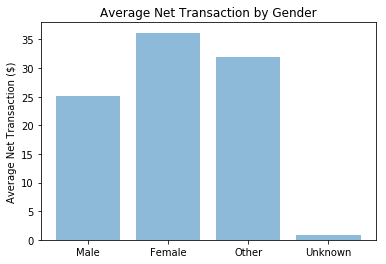

In [163]:
#Average Net Transaction by Gender
# Calculate values for bar graph
avg_male_net = df[df['M']==1]['net_transaction'].sum()/df['M'].sum()
avg_female_net = df[df['F']==1]['net_transaction'].sum()/df['F'].sum()
avg_other_net = df[df['O']==1]['net_transaction'].sum()/df['O'].sum()
avg_unknown_net = df[df['unknown']==1]['net_transaction'].sum()/df['unknown'].sum()

# Make Bar graph
objects = ('Male', 'Female', 'Other', 'Unknown')
y_pos = np.arange(len(objects))
performance = [avg_male_net,avg_female_net,avg_other_net,avg_unknown_net]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average Net Transaction ($)')
plt.title('Average Net Transaction by Gender')

plt.show()

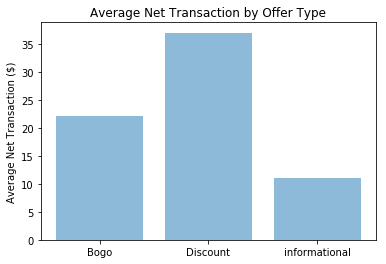

In [164]:
#Average Net Transaction by Offer Type
# Calculate values for bar graph
avg_bogo_net = df[df['bogo']==1]['net_transaction'].sum()/df['bogo'].sum()
avg_discount_net = df[df['discount']==1]['net_transaction'].sum()/df['discount'].sum()
avg_informational_net = df[df['informational']==1]['net_transaction'].sum()/df['informational'].sum()

# Make Bar graph
objects = ('Bogo', 'Discount', 'informational')
y_pos = np.arange(len(objects))
performance = [avg_bogo_net,avg_discount_net,avg_informational_net]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average Net Transaction ($)')
plt.title('Average Net Transaction by Offer Type')

plt.show()

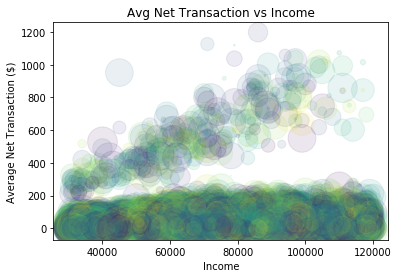

In [165]:
#Avg Net Transaction vs Income
N=df.shape[0]

x_ax = df['income']
y_ax = df['net_transaction']
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x_ax, y_ax, s=area, c=colors, alpha=0.1)
plt.ylabel('Average Net Transaction ($)')
plt.xlabel('Income')
plt.title('Avg Net Transaction vs Income')
plt.show()

In [166]:
#Avg Net Transaction vs Age

x_ax = df['age']
y_ax = df['net_transaction']
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x_ax, y_ax, s=area, c=colors, alpha=0.1)
plt.ylabel('Average Net Transaction ($)')
plt.xlabel('Age')
plt.title('Avg Net Transaction vs Age')
plt.show()

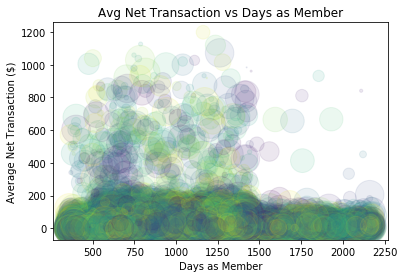

In [167]:
#Avg Net Transaction vs Days as Member

x_ax = df['days_as_member']
y_ax = df['net_transaction']
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x_ax, y_ax, s=area, c=colors, alpha=0.1)
plt.ylabel('Average Net Transaction ($)')
plt.xlabel('Days as Member')
plt.title('Avg Net Transaction vs Days as Member')
plt.show()

#### Net Transaction Summary 

-  Average transaction of those who's gender is uknown is close to zero.  Those who's gender is unknown are the same people who didnt set an age or income.  This suggest that these users don't use the mobile app.
-  Females on average spend most while males spend the least
-  Net transactions are highest on average for discounts and lowest for informationals.
-  Higher net transactions have a higher probability given a higher income.

### Offers Completed

Here we will look at the relationships between offers completed and gender, offer type, income, age, and days as member. 

In [168]:
#Create df of offers completed
offer_df = df[df['offer_completed']==1]

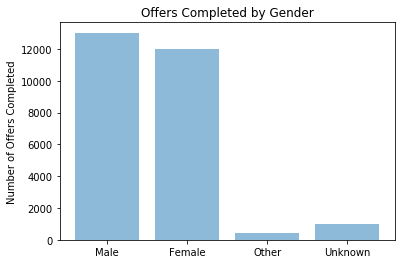

In [169]:
# Make Bar graph of gender
objects = ('Male', 'Female', 'Other', 'Unknown')
y_pos = np.arange(len(objects))
performance = [offer_df['M'].sum(),offer_df['F'].sum(),offer_df['O'].sum(),offer_df['unknown'].sum()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Offers Completed')
plt.title('Offers Completed by Gender')

plt.show()

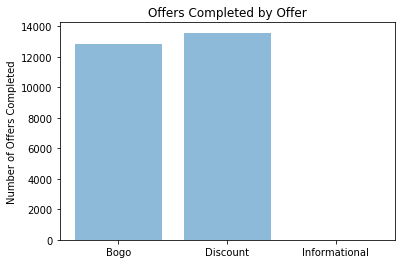

In [170]:
# Make Bar graph of offer type
objects = ('Bogo', 'Discount', 'Informational')
y_pos = np.arange(len(objects))
performance = [offer_df['bogo'].sum(),offer_df['discount'].sum(),offer_df['informational'].sum()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Offers Completed')
plt.title('Offers Completed by Offer')

plt.show()

In [171]:
# Check income distribution
plt.hist(offer_df['income'], bins = 20)

(array([ 1180.,   987.,  1181.,   999.,  1845.,  1940.,  2282.,  1716.,
         2141.,  2259.,  1850.,  1233.,  1645.,  1043.,  1385.,   827.,
          545.,   428.,   526.,   403.]),
 array([  30000.,   34500.,   39000.,   43500.,   48000.,   52500.,
          57000.,   61500.,   66000.,   70500.,   75000.,   79500.,
          84000.,   88500.,   93000.,   97500.,  102000.,  106500.,
         111000.,  115500.,  120000.]),
 <a list of 20 Patch objects>)

(array([  781.,   763.,   772.,   778.,  1141.,  1431.,  1945.,  2290.,
         2724.,  2775.,  2451.,  2201.,  1812.,  1679.,   958.,   804.,
          505.,   351.,   175.,    79.]),
 array([  18.  ,   22.15,   26.3 ,   30.45,   34.6 ,   38.75,   42.9 ,
          47.05,   51.2 ,   55.35,   59.5 ,   63.65,   67.8 ,   71.95,
          76.1 ,   80.25,   84.4 ,   88.55,   92.7 ,   96.85,  101.  ]),
 <a list of 20 Patch objects>)

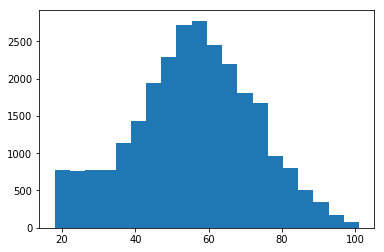

In [172]:
# Check age distribution
plt.hist(offer_df['age'], bins = 20)

(array([ 1650.,  1768.,  3288.,  3372.,  1766.,  1802.,  1734.,  1792.,
         1804.,  1873.,  1662.,  1695.,   277.,   281.,   245.,   260.,
          295.,   286.,   254.,   311.]),
 array([  357.  ,   448.15,   539.3 ,   630.45,   721.6 ,   812.75,
          903.9 ,   995.05,  1086.2 ,  1177.35,  1268.5 ,  1359.65,
         1450.8 ,  1541.95,  1633.1 ,  1724.25,  1815.4 ,  1906.55,
         1997.7 ,  2088.85,  2180.  ]),
 <a list of 20 Patch objects>)

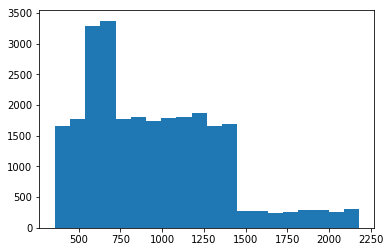

In [173]:
# Check days as member distribution
plt.hist(offer_df['days_as_member'], bins = 20)

### Offers Completed Summary

- Males and females complete similar number of offers.
- Bogo and dicounts completed are similar in number.
- Offers completed for age, income, and days as member mirror the population histograms for each.

## Summary 

- Modeling net transactions performed poorly for predicting individual interactions(highest R squared = 0.109), but modeling correctly predicted the overall success of multiple or individual promotions within 0.3% to 8.6% difference of the actual.
- Modeling offers completed created a good model that can be used in making recommendations.  The model has an F1 score of 0.72.
- Consistent significant modeling predictors(P < 0.05) were female, income, days_as_member, and duration.
- Higher duration and difficulty offers had higher participation.
- Females have a higher average net transaction while having a similar number of offers completed to males.
- Discount offers have a higher average net transaction while having a similar number of offers completed to BOGO offers.
- Higher income individuals have a higher probability to have a higher net transaction.
- Offer participation for age, income, and days as a member mirrior thier population distributions.

#### Challanges

- Vectorizing tasks: There are a number of tasks that use for loops to impute age or income.  For loops cause them to take more time to complete.  If we can vetorize these tasks we would significantly reduce the time it would take to run tasks.
- Pulling dictionary values from a column.  In the transcript dataframe, the value column contains a dictionary.  There were three different objects(offer id, reward, and amount).  I used for loops to pull the values out of the dictionary.  If there is a way to vectorize this it would dramatically reduce the time it take to run the task. 
- Missing data: Age = 118, null gender, and null income values were all missing data.  I chose not to discard them because they made up over 10% of the data.  I imputed the gender as unknown and in the end it showed that this group had very few interactions when compared to males and females.  